In [1]:
import numpy as np
import pandas as pd
##pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)


import re
import nltk
import spacy
import string
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import *
import sklearn.model_selection
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import *
from sklearn.metrics import plot_confusion_matrix

import emot

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Client support

# 1. Data extraction

In [2]:
filename = "../../data/extraction_twint/tweets_data/data_service_clients/with_reply_time/amazon.csv"

In [3]:
full_df = pd.read_csv(filename)

other_features = full_df[["replies_count","retweets_count","likes_count"]]
df = full_df[["tweet","reply_time"]].copy()
df= df.rename(columns={'tweet':'raw'})

In [4]:
full_df.columns

Index(['id', 'conversation_id', 'created_at', 'timezone', 'user_id',
       'username', 'name', 'place', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'datetime',
       'reply_time'],
      dtype='object')

In [5]:
for col in other_features.columns:
    other_features[col]=other_features[col].apply(lambda x: 0 if np.isnan(x) else int(x))

C:\Users\carol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df.columns

Index(['raw', 'reply_time'], dtype='object')

In [13]:
df.head()

,raw,reply_time
0,No I did not only Before they asked my to cancel and reorder and this is not professional. \nNow i wnat my money back im no longer interested in Amazon UK.,NaN
1,Pretty pretty please! #SanditonPBS,NaN
2,When the supernatural series have finished do you have any plans on adding the rest of the series???,NaN
3,"Visited this link, made complain on customer care also but still problem unresolved.. shes not get yet......",NaN
4,Using same account still this pic.twitter.com/IZBO8cVECY,NaN


In [8]:
sum(df.reply_time.isnull())

491

In [9]:
df.shape

(2191, 2)

In [10]:
#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

In [11]:
df.dtypes

raw            object
reply_time    float64
dtype: object

In [12]:
df["raw"] = df["raw"].astype('str')

# 2. Pre-processing

In [14]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

In [15]:
df['has_reply'].value_counts()

True     1700
False     491
Name: has_reply, dtype: int64

### Change text

In [20]:
def remove_uppercase(text):
    return text.lower()
    
def remove_punctuation(text):
    """custom function to remove the punctuation"""  
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_frequent_words(text):
    FREQWORDS = get_frequent_words(df)
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# def remove_urls(text):
#     url_pattern = re.compile(r'https?://\S+|www\.\S+')
#     expression = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*')
#     text =  url_pattern.sub(r'', text)
#     return expression.sub(r'', text)

def remove_urls(text):
    words=[]
    for w in text.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words)


In [23]:
def get_frequent_words(column):
    cnt = Counter()
    for text in column.values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    #RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
    return FREQWORDS

get_frequent_words(df.raw)

{'I', 'a', 'and', 'for', 'is', 'it', 'my', 'the', 'to', 'you'}

### Emoticons to words

In [24]:
def convert_emojis(text):
    #for emot in UNICODE_EMO:
     #   text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    emo= emot.emoji(text)
    #print(emo)
    for i in range(len(emo['value'])):
        text = text.replace(emo['value'][i], emo['mean'][i]).replace(":","")
    return text

#text = "game is on 🔥 🔥 😭"
#print(convert_emojis(text))

### Chat words conversion

In [25]:
words = "../../source/slang.txt"
with open(words, 'r') as file:
    chat_words_str = file.read()

In [26]:
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

#chat_words_conversion("one minute BRB")

In [27]:
#df.raw.apply(chat_words_conversion)

### Stemming

In [28]:
#not so good results

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

#df["stemmed"] = df["raw"].apply(lambda text: stem_words(text))
#df.head()

### Lemmatization

In [29]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                     for word, pos in pos_tagged_text])
    #return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

#ex = "hello I am buying a fruit"
#lemmatize_words(ex)
#df["raw_lemmatized"] = df["raw"].apply(lambda text: lemmatize_words(text))
#df.head()

### Tokenisation

In [30]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#df['tweet_tokenized']=df["tweet_lower"].apply(lambda text: tokenize(text))

# 3. Feature engineering

### Tweet length

In [31]:
df['length']=df['raw'].apply(lambda x:len(x)-x.count(" "))

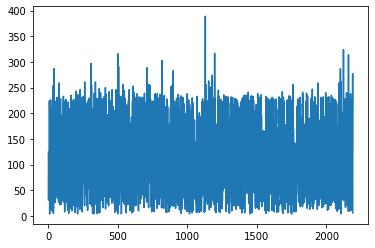

In [32]:
plt.plot(df.length)

In [33]:
plt.hist(df.likes_count, range=(0,5))

AttributeError: 'DataFrame' object has no attribute 'likes_count'

### Punctuation percentage

In [47]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100

df['punct']=df['raw'].apply(count_punct)

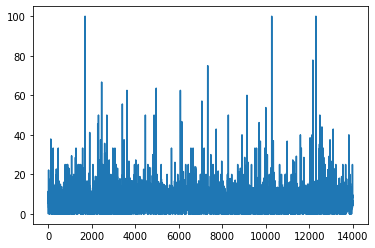

In [48]:
plt.plot(df.punct)

# 4. Data analysis

In [49]:
bins=np.linspace(0,110,40)
plt.hist(df[df.has_reply==True]['replies_count'],bins, alpha=0.5, normed=False, label='Urgent')
plt.hist(df[df.has_reply==False]['replies_count'],bins, alpha=0.5, normed=False, label='Non-Urgent')
plt.legend(loc='upper left')
plt.show()

KeyError: 'replies_count'

Les features calculées n'ont pas l'air de différencier les tweets

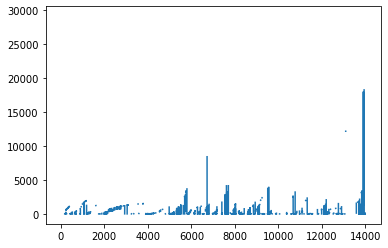

In [50]:
#Distribution of reply times
plt.plot(df['reply_time'])

# 5. Models

# 5A. Model creation 

## 1. Final pre-processing

In [51]:
df["clean_tweet"] = df["raw"].apply(lambda text: remove_uppercase(text))
#df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_punctuation(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_stopwords(text))
#df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text))
df["clean_tweet"] = df["clean_tweet"].apply(lambda text: lemmatize_words(text))

In [52]:
df["clean_tweet_tokenized"] = df["clean_tweet"].apply(lambda text: tokenize(text))

In [53]:
df.columns

Index(['raw', 'reply_time', 'has_reply', 'length', 'punct', 'clean_tweet',
       'clean_tweet_tokenized'],
      dtype='object')

In [54]:
df.head()

,raw,reply_time,has_reply,length,punct,clean_tweet,clean_tweet_tokenized
0,#DAM job opening - Senior Marketing Asset Manager @WholeFoods. More information here: https://careers.wholefoodsmarket.com/global/en/job/WHFOGLOBALREQ20191101322/Senior-Marketing-Asset-Manager …,NaN,False,182,9.9,#dam job open - senior marketing asset manager @wholefoods. information here: https://careers.wholefoodsmarket.com/global/en/job/whfoglobalreq20191101322/senior-marketing-asset-manager …,"[, dam, job, open, senior, marketing, asset, manager, wholefoods, information, here, https, careers, wholefoodsmarket, com, global, en, job, whfoglobalreq20191101322, senior, marketing, asset, manager, ]"
1,"Finally, a holiday I can totally support. I'll take an oatmeal chocolate chip cookie from @WholeFoods. On second thought, I'll take two. #NationalCookieDay https://twitter.com/ClarkDeals/status/1202218566822563840 …",NaN,False,192,8.3,"finally, holiday totally support. i'll take oatmeal chocolate chip cookie @wholefoods. second thought, i'll take two. #nationalcookieday https://twitter.com/clarkdeals/status/1202218566822563840 …","[finally, holiday, totally, support, i, ll, take, oatmeal, chocolate, chip, cookie, wholefoods, second, thought, i, ll, take, two, nationalcookieday, https, twitter, com, clarkdeals, status, 1202218566822563840, ]"
2,@3rdHourTODAY please mention that there are options for hair dye that do not contain the harmful chemicals!!! @WholeFoods carries these!!,NaN,False,118,5.9,@3rdhourtoday please mention option hair dye contain harmful chemicals!!! @wholefoods carry these!!,"[, 3rdhourtoday, please, mention, option, hair, dye, contain, harmful, chemicals, wholefoods, carry, these, ]"
3,"Riddle me this, Whole Foods. How the hell is Mitch McConnell a person of the year anywhere but in Russia?",NaN,False,86,3.5,"riddle this, whole foods. hell mitch mcconnell person year anywhere russia?","[riddle, this, whole, foods, hell, mitch, mcconnell, person, year, anywhere, russia, ]"
4,NEW: Enjoy #Austin Ice Skating on @WholeFoods Rooftop ❄️\n➡️ https://austinot.com/austin-ice-skating-whole-foods … pic.twitter.com/hfHGKwQ66g,NaN,False,130,11.5,new: enjoy #austin ice skate @wholefoods rooftop ❄️ ➡️ https://austinot.com/austin-ice-skating-whole-foods … pic.twitter.com/hfhgkwq66g,"[new, enjoy, austin, ice, skate, wholefoods, rooftop, https, austinot, com, austin, ice, skating, whole, foods, pic, twitter, com, hfhgkwq66g]"


### Create dataset

In [55]:
vectorizer = CountVectorizer(max_features = 1000)
text_features = vectorizer.fit_transform(df.clean_tweet).toarray()

X=np.concatenate((text_features,other_features),axis=1)


In [56]:
# Choose value to predict
y = df.has_reply

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,random_state=44)

In [58]:
useless_variables = [
    full_df,
    df,
    X,
    y,
]
for v in useless_variables:
    del(v)

## 2. Vectorization

In [59]:
def build_model(mode):
    # Intent to use default paramaters for show case
    vect = None
    if mode == 'count':
        vect = CountVectorizer()
    elif mode == 'tf':
        vect = TfidfVectorizer(use_idf=False, norm='l2')
    elif mode == 'tfidf':
        vect = TfidfVectorizer()
    #add n-gram
    else:
        raise ValueError('Mode should be either count or tfidf')
    
    return Pipeline([
        ('vect', vect),
        ('clf' , LogisticRegression(solver='newton-cg',n_jobs=-1))
    ])

## 3. Choose model

### Random Forest

In [72]:
rf = RandomForestClassifier(n_estimators=10, verbose=1, n_jobs=4, class_weight={False: 0.01, True: 0.99})

In [73]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={False: 0.01, True: 0.99}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=4, oob_score=False,
                       random_state=None, verbose=1, warm_start=False)

In [74]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [75]:
model=rf

# 5B. Model evaluation

In [76]:
print('Performance on test set :')
print('\n')

print('Accuracy : %.3f ' % accuracy_score(y_test, y_pred))


Performance on test set :


Accuracy : 0.803 


### Feature importance

### Confusion Matrix

In [77]:
## PRINT SCORES

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


string = "RESULTATS \n \
         Accuracy : {accuracy}% \n \
Balanced Accuracy : {balanced_accuracy}% \n \
         F1 score : {f1}\n \
        Precision : {precision}% (how many selected items are relevant)\n \
           Recall : {recall}% (how many relevant items are selected)\n \
\n\n\
STATISTICS\n\
 Proportion of positives in test set    : {positives}%\n\
 Proportion of positives in predictions : {predicted_positives}%\
"

print(string.format(accuracy = round(100*accuracy,2),
                    balanced_accuracy = round(100*balanced_accuracy,2),
                    f1 = round(f1,4), 
                    precision = round(100*precision,2), 
                    recall = round(100*recall,2),
                    positives = round(100*y_test.sum()/len(y_test),2),
                    predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                   ))

RESULTATS 
          Accuracy : 80.29% 
 Balanced Accuracy : 61.37% 
          F1 score : 0.3491
         Precision : 36.01% (how many selected items are relevant)
            Recall : 33.87% (how many relevant items are selected)
 

STATISTICS
 Proportion of positives in test set    : 15.6%
 Proportion of positives in predictions : 14.67%


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
No handles with labels found to put in legend.


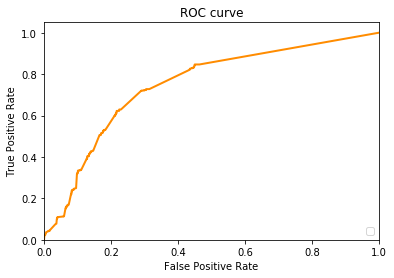

In [78]:
## DISPLAY ROC CURVE
roc = roc_curve(y_test, model.predict_proba(X_test)[:, 1])


plt.plot(roc[0], roc[1], color='darkorange',
         lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Confusion matrix, without normalization
[[2101  263]
 [ 289  148]]
Normalized confusion matrix
[[0.88874788 0.11125212]
 [0.66132723 0.33867277]]


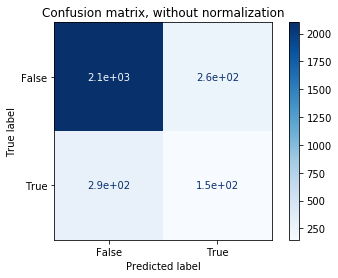

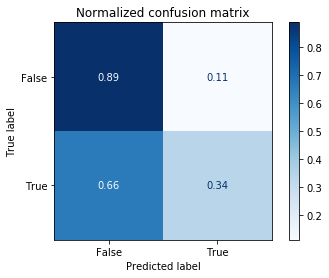

In [79]:
# CONFUSION MATRIX
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [70]:
#SAMPLES DE TOUTES LES CATEGORIES

##on recupere les tweets urgents manqués

#urgents and not urgents tweets index
positives = y_test[y_test==True].index
negatives = y_test[y_test==False].index

#correct and incorrect predictions index
is_prediction_correct = y_test==y_pred
correct_predictions   = is_prediction_correct[is_prediction_correct==True].index
incorrect_predictions = is_prediction_correct[is_prediction_correct==False].index

#true/false positive/negative index
true_positive_index  = correct_predictions.intersection(positives)
true_negative_index  = correct_predictions.intersection(negatives)
false_positive_index = incorrect_predictions.intersection(negatives)
false_negative_index = incorrect_predictions.intersection(positives)

In [71]:
df.loc[true_positive_index][['raw']]

,raw
13886,Not good deals.
6514,Hey Prime members: tell Jeff Bezos to reinstate health benefits for part-time workers.
8798,Where the GOOD shrooms at? 😏
717,Indeed
1242,"Doubled my ire at @WholeFoods. \nRude, untrained staff discussing bacchanalia & hatred of job in the aisles. They argue to argue, e.g. a pasilla IS an ancho, the bulk aisle is NOT out of pencils...\n""Food"" picked a week early and refrigerated.\nStockers in aisles during peak hrs."
7975,Φχαριστω
2855,"Here's the Newsweek article. ""Twitter users have cried foul, though, and now they are trying to boycott the Whole Foods Supermarkets chain, which has nothing to do with the magazine."" I know, unfortunate, right? https://www.newsweek.com/after-mitch-mcconnell-named-wholefoods-magazines-man-year-twitter-users-call-boycott-1474548 …"
6661,"Animal Welfare Certified? The turkey is dead, right?"
12108,Boo hoo whah whah
2619,Thanksgiving Food was delicious!!! Thank you @WholeFoods


In [200]:
df.loc[true_negative_index][['raw']]

,raw
11251,These chocolate chip cookie and caramel pecan cookies from @WholeFoods are bussin
2650,It isn’t true.
4634,Perhaps it’s (Ass) Whole Foods Magazine?
8658,WERE GOING ON 9 DAYS AND NO RESPONSE. It’s fine. I’ll report everything to OSHA. :)
2930,And apparently an endorsement from @JeffBezos and @WholeFoods for some gawdawful reason. https://twitter.com/ominousrabbit/status/1191241391566917632 …
...,...
4519,"We did @WholeFoods for thanksgiving and started a day early. Unfortunately, I woke up with the worst sodium hangover in recent memory So I guess I’ll just stick with pie from now on LOL"
5851,sooo... its a coffee machine ? https://www.shutterstock.com/video/clip-7606117-coffee-machine-dropping-paper-cup-vending-street …
9058,"Wow, people eat."
9640,Awesome.


In [201]:
df.loc[false_positive_index][['raw']]

,raw
13761,sampling from the @WholeFoods salad bar should be a punishable crime! #gross
10882,pic.twitter.com/0CwSFvBBXN
12826,They always have it in stock at the porter ranch location.
6076,£\|{£{¥{
3446,Jesus Christ you guys are a messs. L O L
4321,The magazine has no connection with the store. https://twitter.com/think_teach1/status/1200043637159186432?s=20 …
6720,Chili
2505,@WholeFoodsMag is NOT the same as the @WholeFoods grocery store. https://twitter.com/jilevin/status/1200124300948193280 …
7416,"You’re not fooling anyone, @WholeFoods those are twinkies! pic.twitter.com/BS1npHNqqa"
12644,*ed


In [202]:
df.loc[false_negative_index][['raw']]

,raw
557,"Not after you but Moscow Mitch on your magazine cover, no way will I ever shop there again."
13886,Not good deals.
10970,Any deals for dogs? You know you love them in your stores!\n#HealthCodeViolation
7009,The chantilly cakes. Are. So. Bomb. 🤤
6514,Hey Prime members: tell Jeff Bezos to reinstate health benefits for part-time workers.
8798,Where the GOOD shrooms at? 😏
7419,I think I might be addicted to @WholeFoods mini chocolate croissants. I haven’t had them in a couple of weeks and I keep craving them. Don’t they have to list magic fairy dust on the ingredients label? Send help ... or croissants. pic.twitter.com/qCRmHHALKl
13656,"The butcher @WholeFoods just said, “The grass is greener, depending on how you water it!” #PositiveVibes #atx #quoteoftheday #behappy #positive #bepositive pic.twitter.com/u0hlk2fuzo"
717,Indeed
12639,"I want to thank @WholeFoods for the exceptional customer service I received. They cared about my previous shopping experience and moved very quickly to resolve it. This is what sets @WholeFoods apart from all others, the level of care and customer service!"
